## Oil Price Price Prediction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

# Set max rows and columns to display
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Configure logging
from logging_setup import SetupLogger

logger = SetupLogger(log_file='../logs/notebooks.log').get_logger()

# Set default figure size for all plots
plt.rcParams['figure.figsize'] = (14, 7)
# Read the data
# Load data into a pandas DataFrame
price_data = pd.read_csv('../data/data.csv')
price_data['Date'] = pd.to_datetime(price_data['Date'], format='mixed')
price_data.set_index('Date', inplace=True)

## Feature Engineering
* Generate new features from oil price data

In [3]:
# Load the the price dataset
merged_data = pd.read_csv('../data/features.csv')

### Create New Features from Oil Prices

With the merged data, create new features from the oil prices to capture trends, volatility, and other useful characteristics.

* Percentage Change: Calculate daily percentage changes in oil prices.

* Rolling Average: Use rolling windows to create moving averages (e.g., 7-day, 30-day) to capture trends.

* Volatility: Calculate rolling standard deviation to measure oil price volatility.

* Momentum Indicators: You can create features such as price difference over different periods (e.g., 7-day, 30-day differences).

In [4]:
# Percentage change
merged_data['Price_Pct_Change'] = merged_data['Price'].pct_change()

# Rolling averages (e.g., 7-day and 30-day moving averages)
merged_data['Price_7D_MA'] = merged_data['Price'].rolling(window=7).mean()
merged_data['Price_30D_MA'] = merged_data['Price'].rolling(window=30).mean()

# Rolling volatility (e.g., 7-day and 30-day standard deviation)
merged_data['Price_7D_Volatility'] = merged_data['Price'].rolling(window=7).std()
merged_data['Price_30D_Volatility'] = merged_data['Price'].rolling(window=30).std()

# Price momentum (e.g., 7-day and 30-day difference)
merged_data['Price_7D_Change'] = merged_data['Price'] - merged_data['Price'].shift(7)
merged_data['Price_30D_Change'] = merged_data['Price'] - merged_data['Price'].shift(30)

# Lagged Features
merged_data['Price_7D_Change'] = merged_data['Price'].diff(periods=7)
merged_data['Price_30D_Change'] = merged_data['Price'].diff(periods=30)

In [5]:
merged_data.dropna(inplace=True)
#merged_data.drop(columns=['Rolling_Volatility', 'Segment'], inplace=True)
features = merged_data.set_index('Date')

features

,GDP,Exchange Rate,Price,Price_Pct_Change,Price_7D_MA,Price_30D_MA,Price_7D_Volatility,Price_30D_Volatility,Price_7D_Change,Price_30D_Change
Date,,,,,,,,,,
1999-01-01,3.274709e+13,0.938283,10.54,0.000000,10.212857,9.804333,0.301591,0.411555,0.63,0.83
1999-01-02,3.275013e+13,0.938679,10.54,0.000000,10.302857,9.820667,0.289926,0.430909,0.63,0.49
1999-01-03,3.275316e+13,0.939074,10.54,0.000000,10.392857,9.847667,0.241365,0.449986,0.63,0.81
1999-01-04,3.275620e+13,0.939470,10.94,0.037951,10.540000,9.888000,0.209841,0.491398,1.03,1.21
1999-01-05,3.275924e+13,0.939866,10.30,-0.058501,10.550000,9.907000,0.193649,0.496075,0.07,0.57
...,...,...,...,...,...,...,...,...,...,...
2022-11-08,1.017709e+14,0.949624,96.85,-0.030239,96.575714,93.685333,2.394910,2.984813,2.21,10.88
2022-11-09,1.017709e+14,0.949624,93.05,-0.039236,96.540000,93.802000,2.453059,2.884312,-0.25,3.50
2022-11-10,1.017709e+14,0.949624,94.25,0.012896,96.415714,93.963333,2.556840,2.762986,-0.87,4.84


In [6]:
# Copy your features DataFrame
data = features.copy()

# Ensure the date index is properly formatted
data.index = pd.to_datetime(data.index)

# Create a complete date range and reindex
full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
data = data.reindex(full_date_range)

# Fill missing values using forward fill
data.ffill(inplace=True)  # This will fill NaNs with the last valid observation

# Now you can proceed with your train-validation-test split
train_size = int(len(data) * 0.8)  # Adjust split ratio for train
validation_size = int(len(data) * 0.1)  # Adjust split ratio for validation (10% of total)

# Define train, validation, and test sets
train = data.iloc[:train_size]
validation = data.iloc[train_size:train_size + validation_size]
test = data.iloc[train_size + validation_size:]

# Check for missing values after the split
print("Missing Values in Train:", train.isnull().sum())
print("Missing Values in Validation:", validation.isnull().sum())
print("Missing Values in Test:", test.isnull().sum())

# Optional: Print the sizes of the datasets
print(f"Train Size: {len(train)}")
print(f"Validation Size: {len(validation)}")
print(f"Test Size: {len(test)}")

Missing Values in Train: GDP                     0
Exchange Rate           0
Price                   0
Price_Pct_Change        0
Price_7D_MA             0
Price_30D_MA            0
Price_7D_Volatility     0
Price_30D_Volatility    0
Price_7D_Change         0
Price_30D_Change        0
dtype: int64
Missing Values in Validation: GDP                     0
Exchange Rate           0
Price                   0
Price_Pct_Change        0
Price_7D_MA             0
Price_30D_MA            0
Price_7D_Volatility     0
Price_30D_Volatility    0
Price_7D_Change         0
Price_30D_Change        0
dtype: int64
Missing Values in Test: GDP                     0
Exchange Rate           0
Price                   0
Price_Pct_Change        0
Price_7D_MA             0
Price_30D_MA            0
Price_7D_Volatility     0
Price_30D_Volatility    0
Price_7D_Change         0
Price_30D_Change        0
dtype: int64
Train Size: 6975
Validation Size: 871
Test Size: 873



## Build Model Pipeline
Baseline Model - VAR (Vector Autoregression):

* Use VAR to capture the interdependencies between multiple time series (e.g., GDP, Exchange Rate, and oil price).
* Tune parameters based on lag selection.

MSE: 374.31368855931044, RMSE: 19.347188130560742, MAE: 16.998863962407842


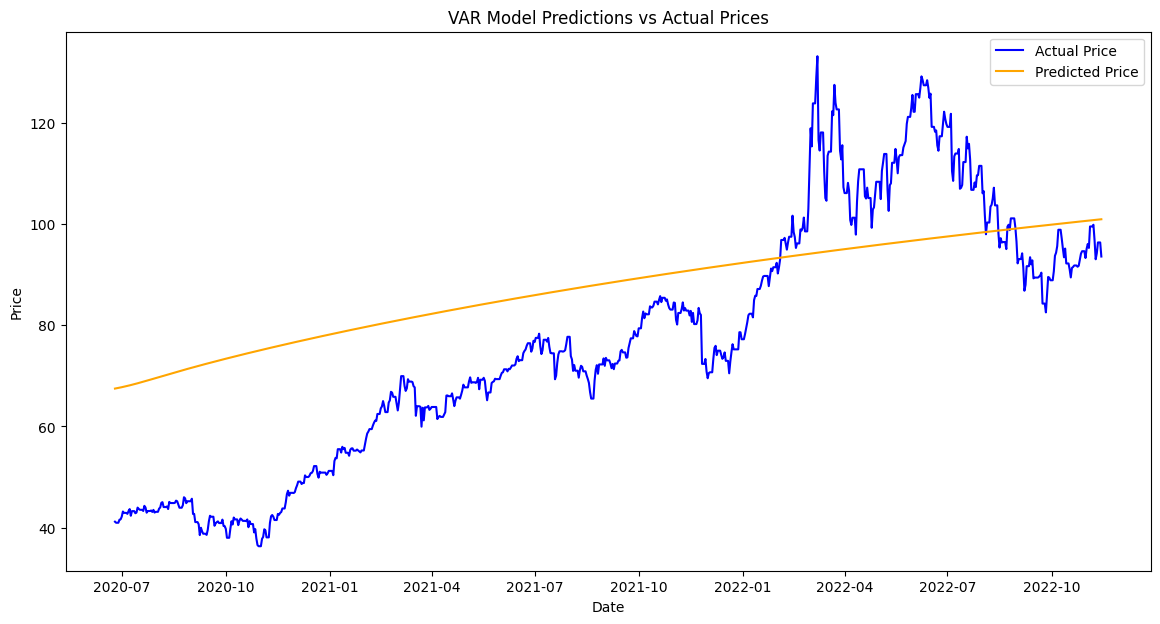

In [7]:
from statsmodels.tsa.api import VAR

# Assuming you have already defined `train` and `test`

# Define VAR Model
def var_model(train, test):
    model = VAR(train)
    model_fit = model.fit()

    # Get the number of lags
    lag_order = model_fit.k_ar

    # Prepare the last 'lag_order' observations for forecasting
    last_obs = train.values[-lag_order:]

    # Forecast the future values
    forecast = model_fit.forecast(last_obs, steps=len(test))

    # Create a DataFrame for the predictions
    predictions = pd.DataFrame(forecast, index=test.index, columns=data.columns)

    # Evaluate the model's performance
    evaluate_model(predictions['Price'], test['Price'])

    return predictions

# Define the evaluation function
def evaluate_model(predictions, actual):
    mse = np.mean((predictions - actual) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - actual))

    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}')

    plt.figure(figsize=(14, 7))
    plt.plot(actual.index, actual, label='Actual Price', color='blue')
    plt.plot(predictions.index, predictions, label='Predicted Price', color='orange')
    plt.title('VAR Model Predictions vs Actual Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Results
predictions_var = var_model(train, test)

MSE: 347.66675798984164, RMSE: 18.645824143486973, MAE: 15.49141905869119


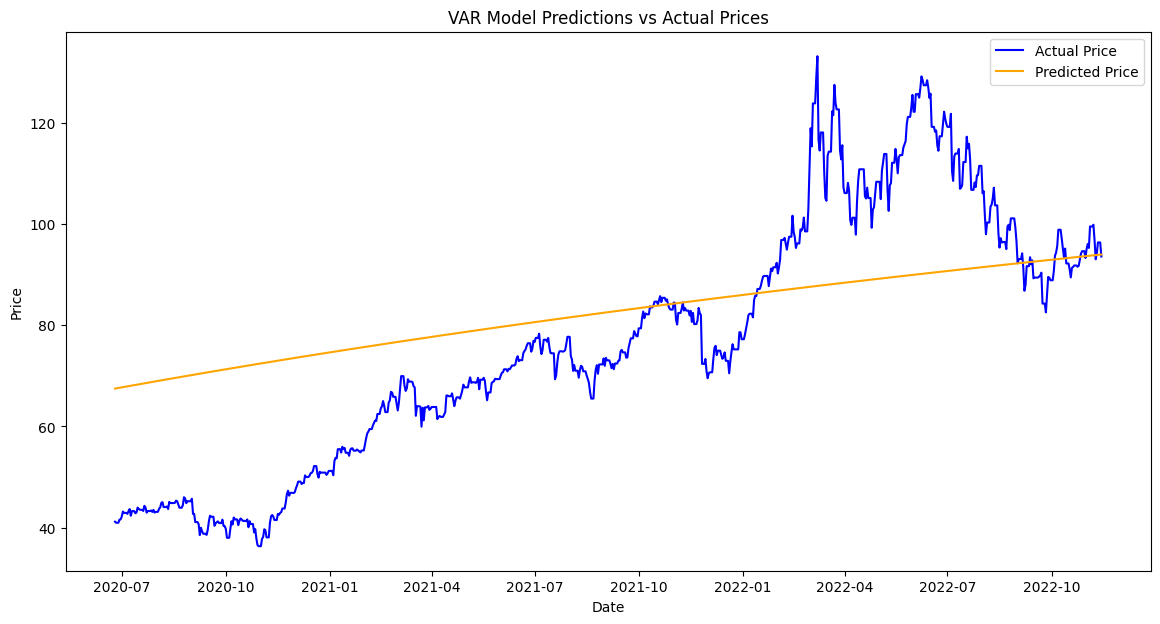

In [8]:
from statsmodels.tsa.api import VAR

# Assuming you have already defined `train` and `test`

# Define VAR Model
def var_model(train, test):
    model = VAR(train[['GDP', 'Exchange Rate', 'Price']])
    model_fit = model.fit()

    # Get the number of lags
    lag_order = model_fit.k_ar

    # Prepare the last 'lag_order' observations for forecasting
    last_obs = train[['GDP', 'Exchange Rate', 'Price']].values[-lag_order:]

    # Forecast the future values
    forecast = model_fit.forecast(last_obs, steps=len(test))

    # Create a DataFrame for the predictions
    predictions = pd.DataFrame(forecast, index=test.index, columns=['GDP', 'Exchange Rate', 'Price'])

    # Evaluate the model's performance
    evaluate_model(predictions['Price'], test['Price'])

    return predictions

# Define the evaluation function
def evaluate_model(predictions, actual):
    mse = np.mean((predictions - actual) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - actual))

    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}')

    plt.figure(figsize=(14, 7))
    plt.plot(actual.index, actual, label='Actual Price', color='blue')
    plt.plot(predictions.index, predictions, label='Predicted Price', color='orange')
    plt.title('VAR Model Predictions vs Actual Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Results
predictions_var = var_model(train, test)


## Advanced Time Series Models - SARIMAX:

* Use SARIMAX to capture seasonal patterns and trends in time series data while incorporating exogenous variables.

* Tune ARIMA parameters (p, d, q) and seasonal parameters (P, D, Q, s) to model different price dynamics effectively.

* Evaluate model performance using metrics such as MSE, RMSE, and MAE, and visualize the results to assess the model's predictive capabilities.

In [9]:
import statsmodels.api as sm

# Function to evaluate the model
def evaluate_model(predictions, actual):
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predictions)

    print(f'MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}')

    plt.figure(figsize=(14, 7))
    plt.plot(actual.index, actual, label='Actual Price', color='blue')
    plt.plot(predictions.index, predictions, label='Predicted Price', color='orange')
    plt.title('Model Predictions vs Actual Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Fit and evaluate SARIMAX model
def sarimax_model(train, test):
    # Define endogenous and exogenous variables
    y_train = train['Price']
    exog_train = train[['GDP', 'Exchange Rate', 'Price_Pct_Change',
                        'Price_7D_MA', 'Price_30D_MA',
                        'Price_7D_Volatility', 'Price_30D_Volatility',
                        'Price_7D_Change', 'Price_30D_Change']]

    y_test = test['Price']
    exog_test = test[['GDP', 'Exchange Rate', 'Price_Pct_Change',
                      'Price_7D_MA', 'Price_30D_MA',
                      'Price_7D_Volatility', 'Price_30D_Volatility',
                      'Price_7D_Change', 'Price_30D_Change']]

    try:
        # Fit the SARIMAX model with adjusted parameters
        model = sm.tsa.SARIMAX(y_train,
                                exog=exog_train,
                                order=(1, 1, 1),   # Start simple
                                seasonal_order=(1, 1, 1, 12),  # Start simple for seasonality
                                enforce_stationarity=False,
                                enforce_invertibility=False)

        results = model.fit(maxiter=1000, disp=False, pgtol=1e-4)  # Adjust convergence settings

        # Forecasting the next values
        forecast = results.get_forecast(steps=len(test), exog=exog_test)
        predictions = forecast.predicted_mean

        # Evaluate the model's performance
        evaluate_model(predictions, y_test)

        return predictions

    except Exception as e:
        print(f"An unexpected error occurred: {e}")


# Fit and evaluate the SARIMAX model
predictions_sarimax = sarimax_model(train, test)

/home/abel/CODE/KiFiya/10-Academy-Week-10/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


An unexpected error occurred: name 'mean_squared_error' is not defined


## Machine Learning Model - LSTM (Long Short-Term Memory) Network:

* Design an LSTM network to capture temporal dependencies in the data.
* Experiment with hyperparameters like layers, dropout rate, learning rate, and batch size.
* Use sequences of past values for each feature as input windows for the LSTM.

2025-02-27 21:22:25.814463: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - loss: 0.0200 - val_loss: 0.0019
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 3.8528e-04 - val_loss: 0.0017
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 4.0815e-04 - val_loss: 0.0015
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 3.8291e-04 - val_loss: 0.0013
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 2.7695e-04 - val_loss: 9.1037e-04
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 2.8622e-04 - val_loss: 0.0016
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 3.3477e-04 - val_loss: 0.0010
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 2.3103e-04 - val_loss: 7.0196e-04
Epoch 9/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 2.1546e-04 - val_loss: 7.6482e-04
Epoch 10/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 1.8453e-04 - val_loss: 0.0010
Epoch 11/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 1.9501e-

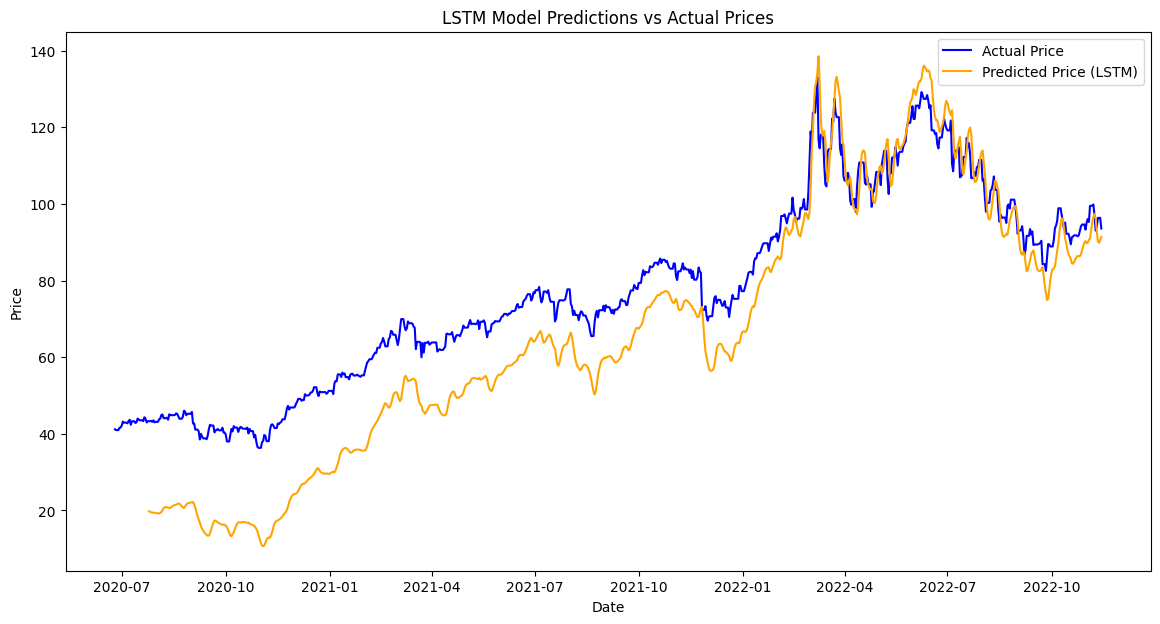

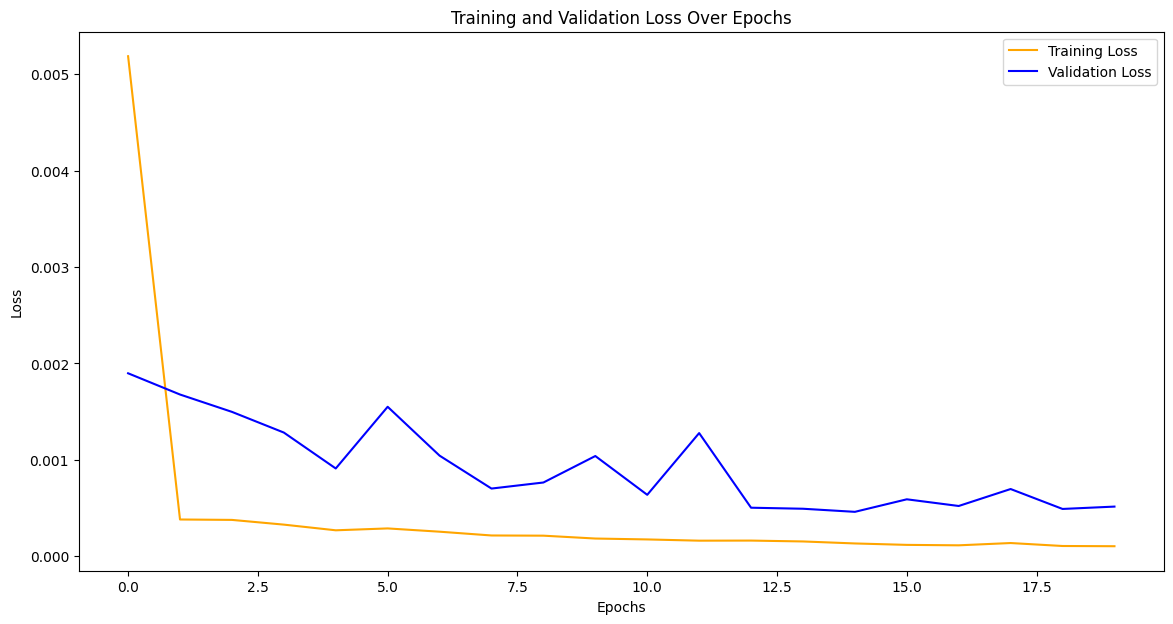

In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping
# Preparing data for LSTM
def prepare_data_lstm(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

    # Create sequences
    X, y = [], []
    for i in range(30, len(scaled_data)):
        X.append(scaled_data[i-30:i])
        y.append(scaled_data[i])

    return np.array(X), np.array(y), scaler

# Assuming train and validation datasets are defined
X_train, y_train, scaler = prepare_data_lstm(train)
X_val, y_val, _ = prepare_data_lstm(validation)  # Prepare validation data

# Build LSTM Model using Input Layer
def create_lstm_model():
    model = Sequential()
    model.add(Input(shape=(30, 1)))  # 30 time steps and 1 feature
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model_lstm = create_lstm_model()

# Define early stopping to protect overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    mode='min',          # Mode can be 'min' for loss
    restore_best_weights=True  # Restore the best weights from training
)
# Train the LSTM Model with validation data
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32,
                          validation_data=(X_val, y_val), callbacks=[early_stopping])  # Include validation data

# Prepare test data
X_test, y_test, _ = prepare_data_lstm(test)

# Predictions
predictions_lstm = model_lstm.predict(X_test)
predictions_lstm = scaler.inverse_transform(predictions_lstm)

# Calculate evaluation metrics
mse = mean_squared_error(test['Price'][30:], predictions_lstm)
mae = mean_absolute_error(test['Price'][30:], predictions_lstm)

print(f'MSE: {mse:.2f}, MAE: {mae:.2f}')

# Visualizing LSTM Predictions
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['Price'], label='Actual Price', color='blue')
plt.plot(test.index[30:], predictions_lstm, label='Predicted Price (LSTM)', color='orange')
plt.title('LSTM Model Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Visualizing Training and Validation Loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()